In [7]:
import random
import matplotlib.pyplot as plt
import numpy as np
import umap
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

#import Lambda
from tensorflow.keras.layers import Lambda

import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,  load_img
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Input, Lambda
#import concatenate
from tensorflow.keras.layers import Concatenate

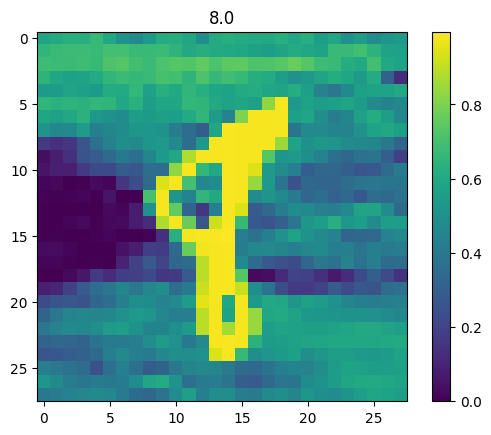

In [217]:
from sklearn.utils import shuffle

# read amat
mnist_back_train_data = np.loadtxt('mnist_background_images/mnist_background_images_train.amat')
mnist_back_test_data = np.loadtxt('mnist_background_images/mnist_background_images_test.amat')

mnist_back_train_label = mnist_back_train_data[:,-1]
mnist_back_test_label = mnist_back_test_data[:,-1]

mnist_back_train_data, mnist_back_train_label = shuffle(mnist_back_train_data, mnist_back_train_label)
mnist_back_test_data, mnist_back_test_label = shuffle(mnist_back_test_data, mnist_back_test_label)

mnist_back_train_data = mnist_back_train_data[:,:-1]
mnist_back_test_data = mnist_back_test_data[:,:-1]

mnist_back_train_data = mnist_back_train_data.reshape(-1, 28, 28, 1)
mnist_back_test_data = mnist_back_test_data.reshape(-1, 28, 28, 1)


# rotate 90 degrees to the right and revert
i = 98
mnist_back_train_data_rotated = np.rot90(mnist_back_train_data, axes=(1,2))
# revert
mnist_back_train_data_rotated = mnist_back_train_data_rotated[:,::-1,:]
plt.imshow(mnist_back_train_data_rotated[i])
plt.title(mnist_back_train_label[i])
plt.colorbar()

In [216]:
# load mnist dataset from keras

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0

classes = list(range(10))

In [13]:
# # # define triplet generator (entire batch)

# def data_generator(batch_size=64):
#     while True:
#         a = []
#         p = []
#         n = []
#         for _ in range(batch_size):
#             # (28,28, 1) to (28, 28, 3) making 3 copies of the image
#             x_test_rgb = tf.tile(x_train, [1, 1, 1, 3])

#             pos_neg = random.sample(classes, 2)
#             positive_samples = random.sample(list(x_test_rgb[y_train == pos_neg[0]]), 2)
#             negative_sample = random.choice(list(x_test_rgb[y_train == pos_neg[1]]))

#             a.append(positive_samples[0])
#             p.append(positive_samples[1])
#             n.append(negative_sample)
#         yield ([np.array(a), np.array(p), np.array(n)], np.zeros((batch_size, 1)).astype('float32'))


In [14]:
# Define triplet generator (current batch)

def data_generator(batch_size=128):
    while True:
        a = []
        p = []
        n = []
        for _ in range(batch_size):
            # Get a batch of input samples from x_train and y_train
            batch_indices = np.random.choice(len(x_train), size=batch_size, replace=False)
            batch_images = x_train[batch_indices]
            batch_labels = y_train[batch_indices]

            # Convert images to RGB
            x_batch_rgb = tf.tile(batch_images, [1, 1, 1, 3])

            # Generate triplet samples
            for i in range(batch_size):
                pos_neg = random.sample(classes, 2)
                positive_samples = random.sample(list(x_batch_rgb[batch_labels == pos_neg[0]]), 2)
                negative_sample = random.choice(list(x_batch_rgb[batch_labels == pos_neg[1]]))

                a.append(positive_samples[0])
                p.append(positive_samples[1])
                n.append(negative_sample)

        yield ([np.array(a), np.array(p), np.array(n)], np.zeros((batch_size, 1)).astype('float32'))


In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

# Define triplet generator (stratified)
def data_generator(batch_size=100):
    while True:
        a = []
        p = []
        n = []

        # Perform stratified sampling on the training data
        stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.5)
        _, stratified_indices = next(stratified_split.split(x_train, y_train))

        # Get a batch of stratified indices
        batch_indices = np.random.choice(stratified_indices, size=batch_size, replace=False)
        batch_images = x_train[batch_indices]
        batch_labels = y_train[batch_indices]

        # Convert images to RGB
        x_batch_rgb = tf.tile(batch_images, [1, 1, 1, 3])

        # Generate triplet samples
        for i in range(batch_size):
            pos_neg = random.sample(classes, 2)
            positive_samples = random.sample(list(x_batch_rgb[batch_labels == pos_neg[0]]), 2)
            negative_sample = random.choice(list(x_batch_rgb[batch_labels == pos_neg[1]]))

            a.append(positive_samples[0])
            p.append(positive_samples[1])
            n.append(negative_sample)

        yield ([np.array(a), np.array(p), np.array(n)], np.zeros((batch_size, 1)).astype('float32'))


In [114]:
from collections import defaultdict

# Define triplet generator (at least two examples per class)
def data_generator(batch_size=64):
    while True:
        a = []
        p = []
        n = []

        # Create a dictionary of indices belonging to each class
        indices = defaultdict(list)
        for index, label in enumerate(y_train):
            indices[label].append(index)

        # Get a batch of random indices (at least two examples per class)

        # garantir que o target apareça no triplet
        # amostrar de cada fonte e montar 64 triplets


        batch_indices = []
        for _ in range(batch_size):
            pos_neg = random.sample(classes, 2)
            batch_indices.append(random.sample(indices[pos_neg[0]], 1)[0])
            batch_indices.append(random.sample(indices[pos_neg[0]], 1)[0])
            batch_indices.append(random.sample(indices[pos_neg[1]], 1)[0])

        # Get a batch of input samples from x_train and y_train
        batch_images = x_train[batch_indices]
        batch_labels = y_train[batch_indices]

        # Convert images to RGB
        # if batch_images.shape[-1] != 3:
        #     x_batch_rgb = tf.tile(batch_images, [1, 1, 1, 3])

        #     # Generate triplet samples
        #     for i in range(batch_size):
        #         a.append(x_batch_rgb[i * 3])
        #         p.append(x_batch_rgb[i * 3 + 1])
        #         n.append(x_batch_rgb[i * 3 + 2])

        # else:
        # Generate triplet samples
        for i in range(batch_size):
            a.append(batch_images[i * 3])
            p.append(batch_images[i * 3 + 1])
            n.append(batch_images[i * 3 + 2])

        yield ([np.array(a), np.array(p), np.array(n)], np.zeros((batch_size, 1)).astype('float32'))


In [126]:
embedding_size = 50


# def make_model():
input_layer = Input((28, 28, 1))
X = Conv2D(32, (3, 3), activation="relu")(input_layer)
X = MaxPool2D()(X)
X = Conv2D(64, (3, 3), activation="relu")(X)
X = MaxPool2D()(X)
X = Flatten()(X)
X = Dense(embedding_size, activation="relu")(X)
model = Model(input_layer, X)


def triplet_loss(y_true, y_pred):
    anchor_out = y_pred[:, 0:embedding_size]
    positive_out = y_pred[:, embedding_size:2*embedding_size]
    negative_out = y_pred[:, 2*embedding_size:3*embedding_size]

    pos_dist = K.sum(K.abs(anchor_out - positive_out), axis=1)
    neg_dist = K.sum(K.abs(anchor_out - negative_out), axis=1)

    probs = K.softmax([pos_dist, neg_dist], axis=0)

    return K.mean(K.abs(probs[0]) + K.abs(1.0 - probs[1]))


# def make_triplet_model():
triplet_model_a = Input((28, 28, 1))
triplet_model_p = Input((28, 28, 1))
triplet_model_n = Input((28, 28, 1))

triplet_model_out = Concatenate()([model(triplet_model_a), model(triplet_model_p), model(triplet_model_n)])
triplet_model = Model([triplet_model_a, triplet_model_p, triplet_model_n], triplet_model_out)

triplet_model.compile(loss = triplet_loss, optimizer='adam')

In [128]:
history = triplet_model.fit(data_generator(), epochs=10, steps_per_epoch=200, verbose=1)

Epoch 1/10
200/200 [==============================] - 6s 24ms/step - loss: 0.1516
Epoch 2/10
200/200 [==============================] - 5s 24ms/step - loss: 0.0614
Epoch 3/10
200/200 [==============================] - 5s 24ms/step - loss: 0.0383
Epoch 4/10
200/200 [==============================] - 5s 24ms/step - loss: 0.0370
Epoch 5/10
200/200 [==============================] - 5s 24ms/step - loss: 0.0377
Epoch 6/10
200/200 [==============================] - 5s 24ms/step - loss: 0.0333
Epoch 7/10
200/200 [==============================] - 5s 24ms/step - loss: 0.0257
Epoch 8/10
200/200 [==============================] - 5s 24ms/step - loss: 0.0274
Epoch 9/10
200/200 [==============================] - 5s 24ms/step - loss: 0.0215
Epoch 10/10
200/200 [==============================] - 5s 23ms/step - loss: 0.0224


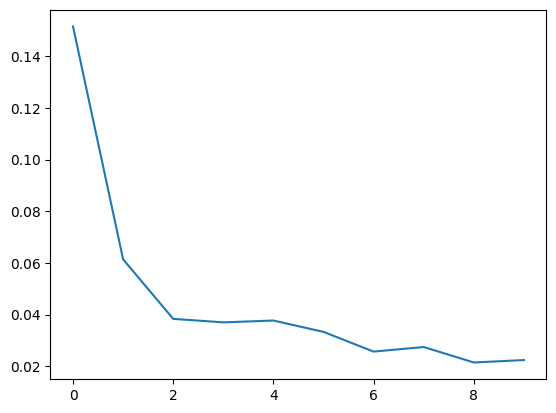

In [129]:
# plot ploss

plt.plot(history.history['loss'])

In [ ]:
# x_test = tf.tile(x_test, [1, 1, 1, 3])
# x_train = tf.tile(x_train, [1, 1, 1, 3])

Avaliacao no teste

In [118]:

model_embeddings_train = triplet_model.layers[3].predict(x_train)

1875/1875 [==============================] - 5s 3ms/step


In [119]:
model_embeddings_train.shape

(60000, 50)

In [15]:
# model_embeddings_test =  triplet_model.layers[3].predict(mnist_back_test_data)

1563/1563 [==============================] - 4s 2ms/step


In [16]:
# model_embeddings_test.shape

(50000, 20)

In [120]:
reduced_embeddings_train = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='correlation').fit_transform(model_embeddings_train)
print(reduced_embeddings_train.shape)

(60000, 2)


In [18]:
# reduced_embeddings_test = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='correlation').fit_transform(model_embeddings_test)
# print(reduced_embeddings_test.shape)

(50000, 2)


train

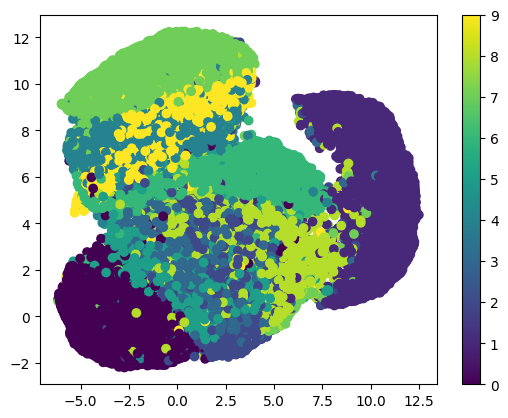

In [121]:
plt.scatter(reduced_embeddings_train[:, 0], reduced_embeddings_train[:,1], c=y_train)
plt.colorbar()

test

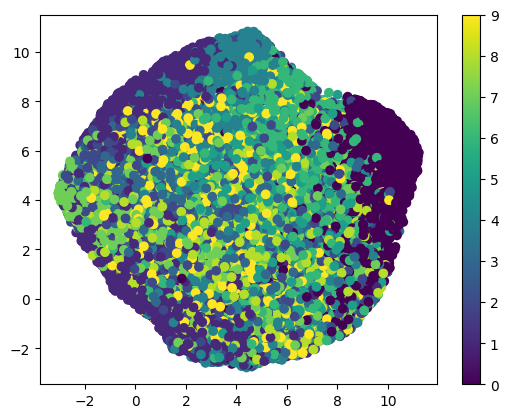

In [22]:
plt.scatter(reduced_embeddings_test[:, 0], reduced_embeddings_test[:,1], c=mnist_back_test_label)
plt.colorbar()

# Classificador
 tentar knn - regularizacao - pca

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


rf = RandomForestClassifier(n_estimators=50)
lr = LogisticRegression()

rf.fit(model_embeddings_train, y_train)
lr.fit(model_embeddings_train, y_train)

print(rf.score(model_embeddings_train, y_train))
print(lr.score(model_embeddings_train, y_train))

c:\Users\levy\miniconda3\envs\keras\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9999333333333333
0.9762333333333333


In [29]:
from sklearn.metrics import accuracy_score

print(accuracy_score(mnist_back_test_label, rf.predict(model_embeddings_test)))
print(accuracy_score(mnist_back_test_label, lr.predict(model_embeddings_test)))

0.18214
0.18642


In [ ]:
# from sklearn.metrics import accuracy_score

# print(accuracy_score(y_train_m, rf.predict(model_embeddings_train_m)))
# print(accuracy_score(y_train_m, lr.predict(model_embeddings_train_m)))

juntar as imagens do mnist e mnist m na mesma classe

In [7]:
# juntar as imagens do mnist e mnistm na mesma classe

# Path: mnistm.py
import os
import numpy as np
from PIL import Image
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# each folder contains images of a specific digit
# root folder "/mnistm_labels"
def load_mnistm():
    root = "mnistm_labels"
    folders = os.listdir(root)
    images = []
    labels = []
    for folder in folders:
        for image_path in os.listdir(os.path.join(root, folder)):
            image = Image.open(os.path.join(root, folder, image_path))
            image = np.array(image)
            images.append(image)
            labels.append(int(folder))
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# load mnistm dataset


In [10]:
x_train.shape

TensorShape([60000, 28, 28, 3])

In [48]:
mnist_back_train_data.shape

(50000, 28, 28)

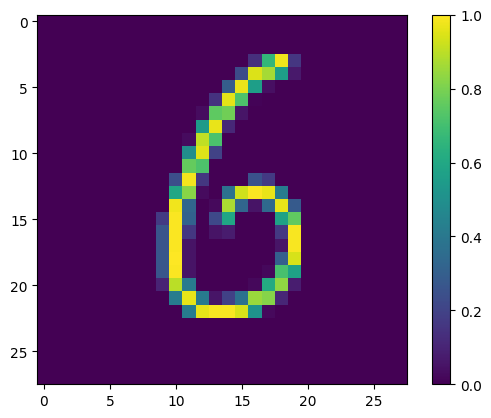

In [18]:
plt.imshow(x_train[18])
plt.colorbar()

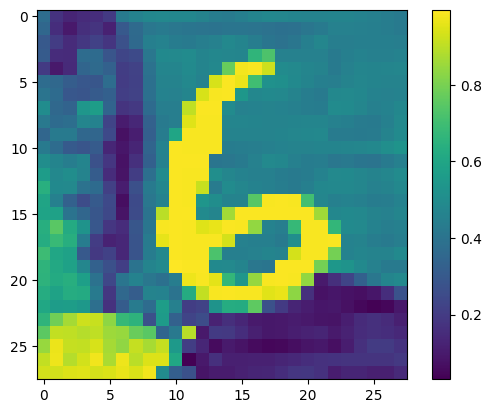

In [19]:
plt.imshow(mnist_back_train_data_rotated[29])
plt.colorbar()

In [30]:
x_train.shape

(60000, 28, 28, 1)

In [21]:
mnist_back_train_data_rotated.shape

(12000, 28, 28, 1)

In [20]:
mnist_back_train_label

array([9., 0., 3., ..., 4., 1., 3.])

In [69]:
def gather_all_images(original, modified, original_y, modified_y):
    all_images = np.concatenate([original, modified], axis=0)
    all_labels = np.concatenate([original_y, modified_y], axis=0)
    return all_images, all_labels


# all_images, all_labels = gather_all_images()
# all_images = np.concatenate([x_train, mnist_back_train_data_rotated], axis=0)
# display(all_images.shape)

# all_labels = np.concatenate([y_train, mnist_back_train_label], axis=0)

# display(all_labels.shape)

In [104]:
all_images.shape

(66000, 28, 28, 1)

# retreinar o modelo usando as novas imagens

garantir que o modelo vai ler o mnist modificado

In [ ]:
# # x_train = all_images
# # y_train = all_labels
# from collections import defaultdict

# # Define triplet generator (at least two examples per class)
# def data_generator(batch_size=64):
#     while True:
#         a = []
#         p = []
#         n = []

#         # Create a dictionary of indices belonging to each class in the original MNIST dataset
#         indices = defaultdict(list)
#         for index, label in enumerate(y_train):
#             indices[label].append(index)

#         # Create a dictionary of indices belonging to each class in the modified MNIST dataset
#         indices_modified = defaultdict(list)
#         for index, label in enumerate(y_train_m):
#             indices_modified[label].append(index)

#         # Get a batch of random indices (at least two examples per class)
#         batch_indices = []
#         batch_indices_p = []
#         batch_indices_n = []
#         for _ in range(batch_size):
#             pos_neg = random.sample(list(indices_modified.keys()), 2)
#             anchor_index = random.sample(indices_modified[pos_neg[0]], 1)[0]
#             positive_index = random.sample(indices_modified[pos_neg[0]], 1)[0]
#             negative_index = random.sample(indices_modified[pos_neg[1]], 1)[0]
#             batch_indices.append(anchor_index)
#             batch_indices_p.append(positive_index)
#             batch_indices_n.append(negative_index)

#         # Get a batch of input samples from x_train and x_train_m
#         batch_images_anchor = np.array([x_train_m[idx] for idx in batch_indices])
#         batch_images_positive = np.array([x_train_m[idx] for idx in batch_indices_p])
#         batch_images_negative = np.array([x_train_m[idx] for idx in batch_indices_n])


#         for i in range(batch_size):
#             # Get anchor image
#             anchor_image = batch_images_anchor[i]
#             # Get positive image
#             pos_image = batch_images_positive[i]
#             # Get negative image
#             neg_image = batch_images_negative[i]

#             # Append samples to their respective lists
#             a.append(anchor_image)
#             p.append(pos_image)
#             n.append(neg_image)

#         yield ([np.array(a), np.array(p), np.array(n)], np.zeros((batch_size, 1)).astype('float32'))



# triplet_model.fit(data_generator(), epochs=5, steps_per_epoch=150)

# todo mundo junto

In [33]:
from collections import defaultdict

# Define triplet generator (at least two examples per class)
def data_generator_todos_juntos(batch_size=64):
    while True:
        a = []
        p = []
        n = []

        # Create a dictionary of indices belonging to each class
        indices = defaultdict(list)
        for index, label in enumerate(all_labels):
            indices[label].append(index)

        # Get a batch of random indices (at least two examples per class)

        # garantir que o target apareça no triplet
        # amostrar de cada fonte e montar 64 triplets


        batch_indices = []
        for _ in range(batch_size):
            pos_neg = random.sample(classes, 2)
            batch_indices.append(random.sample(indices[pos_neg[0]], 1)[0])
            batch_indices.append(random.sample(indices[pos_neg[0]], 1)[0])
            batch_indices.append(random.sample(indices[pos_neg[1]], 1)[0])

        # Get a batch of input samples from x_train and y_train
        batch_images = all_images[batch_indices]

 
        for i in range(batch_size):
            a.append(batch_images[i * 3])
            p.append(batch_images[i * 3 + 1])
            n.append(batch_images[i * 3 + 2])

        yield ([np.array(a), np.array(p), np.array(n)], np.zeros((batch_size, 1)).astype('float32'))


trying to get the 121

# treinamento personalizado

In [156]:
from collections import defaultdict

# Define triplet generator (at least two examples per class)
def data_generator_personalizado(modified_train_data, modified_train_label, batch_size=64):
    while True:
        a = []
        p = []
        n = []

        # Create a dictionary of indices belonging to each class
        indices = defaultdict(list)
        for index, label in enumerate(y_train):
            indices[label].append(index)

        indices_mnist_back = defaultdict(list)
        for index, label in enumerate(modified_train_label):
            indices_mnist_back[label].append(index)
        

        # Get a batch of random indices (at least two examples per class)

        # garantir que o target apareça no triplet
        # amostrar de cada fonte e montar 64 triplets


        batch_indices = {
            'anchor': [],
            'positive': [],
            'negative': []
        }
        for _ in range(batch_size):
            pos_neg = random.sample(classes, 2)
            # batch_indices.append(random.sample(indices[pos_neg[0]], 1)[0])
            # batch_indices.append(random.sample(indices_mnist_back[pos_neg[0]], 1)[0])
            # batch_indices.append(random.sample(indices[pos_neg[1]], 1)[0])
            batch_indices['anchor'].append(random.sample(indices[pos_neg[0]], 1)[0])
            batch_indices['positive'].append(random.sample(indices_mnist_back[pos_neg[0]], 1)[0])
            batch_indices['negative'].append(random.sample(indices[pos_neg[1]], 1)[0])


        # Get a batch of input samples from x_train and y_train
        # batch_images_original = all_images[batch_indices]
        batch_images = {
            'anchor': x_train[batch_indices['anchor']],
            'positive': modified_train_data[batch_indices['positive']],
            'negative': x_train[batch_indices['negative']]
        }

 
        # for i in range(batch_size):
        #     a.append(batch_images[i * 3])
        #     p.append(batch_images[i * 3 + 1])
        #     n.append(batch_images[i * 3 + 2])


        for i in range(batch_size):
            # Get anchor image
            anchor_image = batch_images['anchor'][i]
            # Get positive image
            pos_image = batch_images['positive'][i]
            # Get negative image
            neg_image = batch_images['negative'][i]

            # Append samples to their respective lists
            a.append(anchor_image)
            p.append(pos_image)
            n.append(neg_image)

        yield ([np.array(a), np.array(p), np.array(n)], np.zeros((batch_size, 1)).astype('float32'))


In [35]:
triplet_model.fit(data_generator_personalizado(), epochs=10, steps_per_epoch=150)

Epoch 1/10
150/150 [==============================] - 27s 31ms/step - loss: 0.2381
Epoch 2/10
150/150 [==============================] - 4s 28ms/step - loss: 0.0935
Epoch 3/10
150/150 [==============================] - 4s 27ms/step - loss: 0.0572
Epoch 4/10
150/150 [==============================] - 4s 27ms/step - loss: 0.0530
Epoch 5/10
150/150 [==============================] - 4s 27ms/step - loss: 0.0418
Epoch 6/10
150/150 [==============================] - 4s 27ms/step - loss: 0.0397
Epoch 7/10
150/150 [==============================] - 4s 27ms/step - loss: 0.0362
Epoch 8/10
150/150 [==============================] - 4s 27ms/step - loss: 0.0348
Epoch 9/10
150/150 [==============================] - 4s 28ms/step - loss: 0.0328
Epoch 10/10
150/150 [==============================] - 4s 27ms/step - loss: 0.0302


In [15]:
model_embeddings_train_m = triplet_model.layers[3].predict(mnist_back_train_data_rotated)

375/375 [==============================] - 2s 2ms/step


In [16]:
model_embeddings_train_m.shape

(12000, 20)

In [17]:
reduced_embeddings_train_m = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='correlation').fit_transform(model_embeddings_train_m)
print(reduced_embeddings_train_m.shape)

(12000, 2)


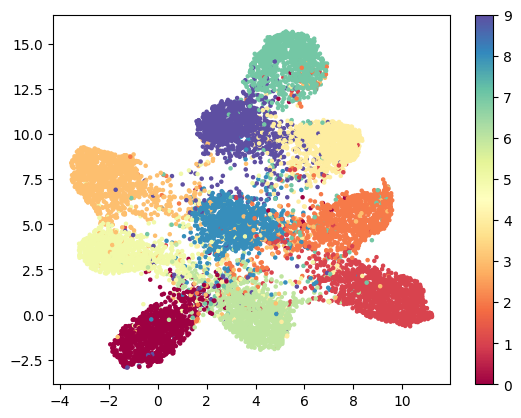

In [112]:
plt.scatter(reduced_embeddings_train_m[:, 0], reduced_embeddings_train_m[:,1], c=mnist_back_train_label, cmap='Spectral', s=5)
plt.colorbar()

121

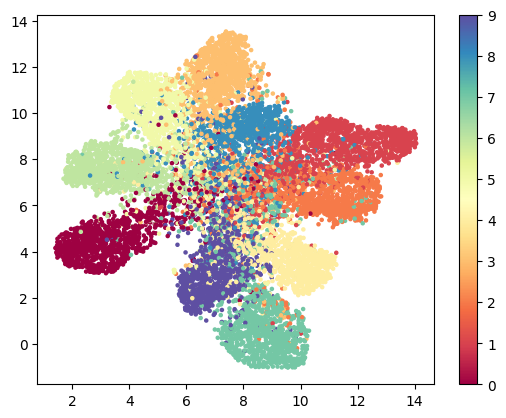

In [18]:
plt.scatter(reduced_embeddings_train_m[:, 0], reduced_embeddings_train_m[:,1], c=mnist_back_train_label, cmap='Spectral', s=5)
plt.colorbar()

# Reduzir o domínio target faz reduzir o poder preditivo ?

## 10%

In [146]:
def new_model():
    embedding_size = 50


    # def make_model():
    input_layer = Input((28, 28, 1))
    X = Conv2D(32, (3, 3), activation="relu")(input_layer)
    X = MaxPool2D()(X)
    X = Conv2D(64, (3, 3), activation="relu")(X)
    X = MaxPool2D()(X)
    X = Flatten()(X)
    X = Dense(embedding_size, activation="relu")(X)
    model = Model(input_layer, X)


    def triplet_loss(y_true, y_pred):
        anchor_out = y_pred[:, 0:embedding_size]
        positive_out = y_pred[:, embedding_size:2*embedding_size]
        negative_out = y_pred[:, 2*embedding_size:3*embedding_size]

        pos_dist = K.sum(K.abs(anchor_out - positive_out), axis=1)
        neg_dist = K.sum(K.abs(anchor_out - negative_out), axis=1)

        probs = K.softmax([pos_dist, neg_dist], axis=0)

        return K.mean(K.abs(probs[0]) + K.abs(1.0 - probs[1]))


    # def make_triplet_model():
    triplet_model_a = Input((28, 28, 1))
    triplet_model_p = Input((28, 28, 1))
    triplet_model_n = Input((28, 28, 1))

    triplet_model_out = Concatenate()([model(triplet_model_a), model(triplet_model_p), model(triplet_model_n)])
    triplet_model = Model([triplet_model_a, triplet_model_p, triplet_model_n], triplet_model_out)

    triplet_model.compile(loss = triplet_loss, optimizer='adam')

    return triplet_model

In [147]:
triplet_model = new_model()
all_images, all_labels = gather_all_images(x_train, mnist_back_train_data_rotated[:1200], y_train, mnist_back_train_label[:1200])

triplet_model.fit(data_generator_todos_juntos(), epochs=10, steps_per_epoch=150)

Epoch 1/10
150/150 [==============================] - 6s 29ms/step - loss: 0.1959
Epoch 2/10
150/150 [==============================] - 4s 27ms/step - loss: 0.0892
Epoch 3/10
150/150 [==============================] - 4s 27ms/step - loss: 0.0659
Epoch 4/10
150/150 [==============================] - 4s 27ms/step - loss: 0.0601
Epoch 5/10
150/150 [==============================] - 4s 28ms/step - loss: 0.0503
Epoch 6/10
150/150 [==============================] - 4s 29ms/step - loss: 0.0433
Epoch 7/10
150/150 [==============================] - 4s 29ms/step - loss: 0.0442
Epoch 8/10
150/150 [==============================] - 4s 28ms/step - loss: 0.0411
Epoch 9/10
150/150 [==============================] - 4s 28ms/step - loss: 0.0357
Epoch 10/10
150/150 [==============================] - 4s 28ms/step - loss: 0.0338


In [148]:
# make clusters

model_embeddings_train_m = triplet_model.layers[3].predict(mnist_back_train_data_rotated)

model_embeddings_train_m.shape

375/375 [==============================] - 1s 3ms/step


(12000, 50)

In [149]:
reduced_embeddings_train_m = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='correlation').fit_transform(model_embeddings_train_m)

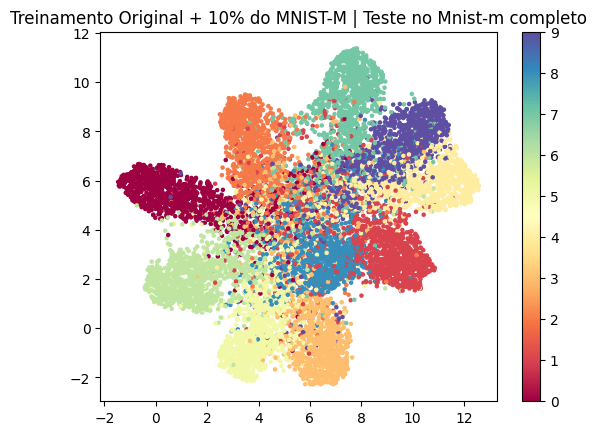

In [150]:
plt.scatter(reduced_embeddings_train_m[:, 0], reduced_embeddings_train_m[:,1], c=mnist_back_train_label, cmap='Spectral', s=5)
plt.title("Treinamento Original + 10% do MNIST-M | Teste no Mnist-m completo")
plt.colorbar()

## 50%

In [79]:
0.5*12000

6000.0

In [151]:
triplet_model_50 = new_model()
all_images, all_labels = gather_all_images(x_train, mnist_back_train_data_rotated[:6000], y_train, mnist_back_train_label[:6000])

triplet_model_50.fit(data_generator_todos_juntos(), epochs=10, steps_per_epoch=150)

Epoch 1/10
150/150 [==============================] - 6s 29ms/step - loss: 0.2405
Epoch 2/10
150/150 [==============================] - 4s 29ms/step - loss: 0.1136
Epoch 3/10
150/150 [==============================] - 4s 29ms/step - loss: 0.1013
Epoch 4/10
150/150 [==============================] - 4s 29ms/step - loss: 0.0864
Epoch 5/10
150/150 [==============================] - 4s 29ms/step - loss: 0.0685
Epoch 6/10
150/150 [==============================] - 4s 29ms/step - loss: 0.0569
Epoch 7/10
150/150 [==============================] - 4s 29ms/step - loss: 0.0560
Epoch 8/10
150/150 [==============================] - 4s 29ms/step - loss: 0.0506
Epoch 9/10
150/150 [==============================] - 4s 29ms/step - loss: 0.0466
Epoch 10/10
150/150 [==============================] - 4s 29ms/step - loss: 0.0500


375/375 [==============================] - 1s 3ms/step


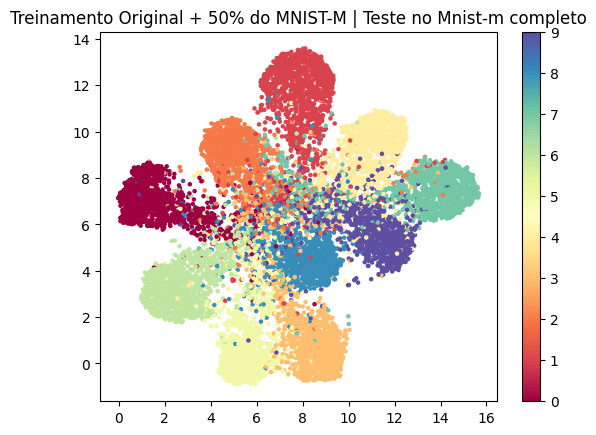

In [152]:
# make clusters

model_embeddings_train_m = triplet_model_50.layers[3].predict(mnist_back_train_data_rotated)

model_embeddings_train_m.shape

reduced_embeddings_train_m = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='correlation')\
    .fit_transform(model_embeddings_train_m)

plt.scatter(reduced_embeddings_train_m[:, 0], reduced_embeddings_train_m[:,1], c=mnist_back_train_label, cmap='Spectral', s=5)
plt.title("Treinamento Original + 50% do MNIST-M | Teste no Mnist-m completo")
plt.colorbar()

## 100%

In [153]:
triplet_model = new_model()

all_images, all_labels = gather_all_images(x_train, mnist_back_train_data_rotated, y_train, mnist_back_train_label)

history = triplet_model.fit(data_generator_todos_juntos(), epochs=10, steps_per_epoch=150)

Epoch 1/10
150/150 [==============================] - 6s 32ms/step - loss: 0.2877
Epoch 2/10
150/150 [==============================] - 5s 31ms/step - loss: 0.1592
Epoch 3/10
150/150 [==============================] - 5s 31ms/step - loss: 0.1134
Epoch 4/10
150/150 [==============================] - 5s 32ms/step - loss: 0.0931
Epoch 5/10
150/150 [==============================] - 5s 30ms/step - loss: 0.0825
Epoch 6/10
150/150 [==============================] - 5s 32ms/step - loss: 0.0712
Epoch 7/10
150/150 [==============================] - 5s 32ms/step - loss: 0.0619
Epoch 8/10
150/150 [==============================] - 5s 32ms/step - loss: 0.0624
Epoch 9/10
150/150 [==============================] - 5s 31ms/step - loss: 0.0607
Epoch 10/10
150/150 [==============================] - 5s 31ms/step - loss: 0.0493


375/375 [==============================] - 1s 3ms/step


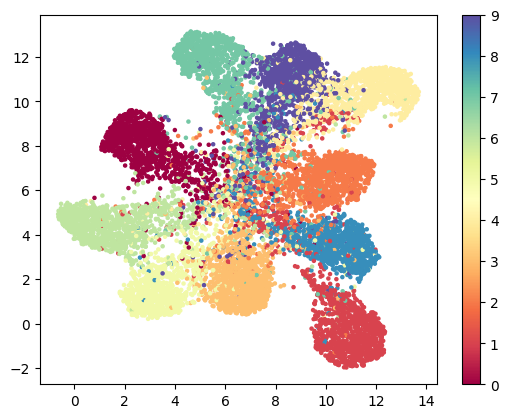

In [154]:
# make clusters

model_embeddings_train_m = triplet_model.layers[3].predict(mnist_back_train_data_rotated)

model_embeddings_train_m.shape

reduced_embeddings_train_m = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='correlation').fit_transform(model_embeddings_train_m)

plt.scatter(reduced_embeddings_train_m[:, 0], reduced_embeddings_train_m[:,1], c=mnist_back_train_label, cmap='Spectral', s=5)
plt.colorbar()

# Versão treinamento personalizado

## 10%

In [159]:
# take 10% of training, append to original mnist and train, verify clusters
triplet_model_p_10 = new_model()

modified_train_data, modified_train_label = mnist_back_train_data_rotated[:1200], mnist_back_train_label[:1200]

history = triplet_model_p_10.fit(data_generator_personalizado(
    modified_train_data, modified_train_label), epochs=10, steps_per_epoch=150)

Epoch 1/10
150/150 [==============================] - 5s 23ms/step - loss: 0.1474
Epoch 2/10
150/150 [==============================] - 4s 24ms/step - loss: 0.0607
Epoch 3/10
150/150 [==============================] - 4s 24ms/step - loss: 0.0442
Epoch 4/10
150/150 [==============================] - 3s 23ms/step - loss: 0.0458
Epoch 5/10
150/150 [==============================] - 4s 24ms/step - loss: 0.0306
Epoch 6/10
150/150 [==============================] - 4s 24ms/step - loss: 0.0346
Epoch 7/10
150/150 [==============================] - 4s 25ms/step - loss: 0.0290
Epoch 8/10
150/150 [==============================] - 4s 24ms/step - loss: 0.0283
Epoch 9/10
150/150 [==============================] - 4s 24ms/step - loss: 0.0205
Epoch 10/10
150/150 [==============================] - 4s 24ms/step - loss: 0.0258


375/375 [==============================] - 1s 3ms/step


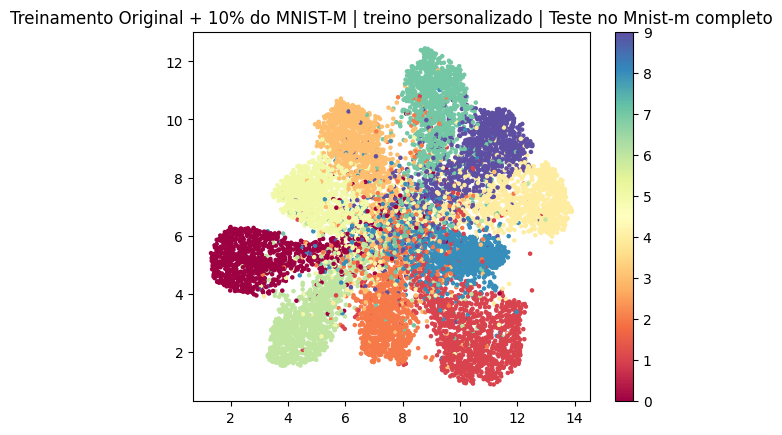

In [162]:
# make clusters

model_embeddings_train_m = triplet_model_p_10.layers[3].predict(mnist_back_train_data_rotated)

model_embeddings_train_m.shape

reduced_embeddings_train_m = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='correlation').fit_transform(model_embeddings_train_m)

plt.scatter(reduced_embeddings_train_m[:, 0], reduced_embeddings_train_m[:,1], c=mnist_back_train_label, cmap='Spectral', s=5)
plt.title("Treinamento Original + 10% do MNIST-M | treino personalizado")
plt.colorbar()

## 50%

In [163]:
# take 10% of training, append to original mnist and train, verify clusters
triplet_model_p_50 = new_model()

modified_train_data, modified_train_label = mnist_back_train_data_rotated[:6000], mnist_back_train_label[:6000]

history = triplet_model_p_50.fit(data_generator_personalizado(
    modified_train_data, modified_train_label), epochs=10, steps_per_epoch=150)

Epoch 1/10
150/150 [==============================] - 5s 26ms/step - loss: 0.1586
Epoch 2/10
150/150 [==============================] - 4s 27ms/step - loss: 0.0593
Epoch 3/10
150/150 [==============================] - 4s 25ms/step - loss: 0.0454
Epoch 4/10
150/150 [==============================] - 4s 25ms/step - loss: 0.0451
Epoch 5/10
150/150 [==============================] - 4s 25ms/step - loss: 0.0361
Epoch 6/10
150/150 [==============================] - 4s 25ms/step - loss: 0.0294
Epoch 7/10
150/150 [==============================] - 4s 25ms/step - loss: 0.0273
Epoch 8/10
150/150 [==============================] - 4s 24ms/step - loss: 0.0261
Epoch 9/10
150/150 [==============================] - 4s 25ms/step - loss: 0.0261
Epoch 10/10
150/150 [==============================] - 4s 26ms/step - loss: 0.0223


375/375 [==============================] - 1s 3ms/step


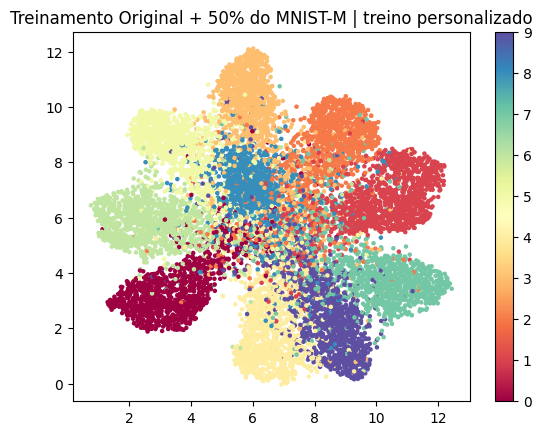

In [165]:
# make clusters

model_embeddings_train_m = triplet_model_p_50.layers[3].predict(mnist_back_train_data_rotated)

model_embeddings_train_m.shape

reduced_embeddings_train_m = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='correlation').fit_transform(model_embeddings_train_m)

plt.scatter(reduced_embeddings_train_m[:, 0], reduced_embeddings_train_m[:,1], c=mnist_back_train_label, cmap='Spectral', s=5)
plt.title("Treinamento Original + 50% do MNIST-M | treino personalizado")
plt.colorbar()

## 100%

In [166]:
# take 10% of training, append to original mnist and train, verify clusters
triplet_model_p_100 = new_model()

modified_train_data, modified_train_label = mnist_back_train_data_rotated, mnist_back_train_label

history = triplet_model_p_100.fit(data_generator_personalizado(
    modified_train_data, modified_train_label), epochs=10, steps_per_epoch=150)

Epoch 1/10
150/150 [==============================] - 6s 28ms/step - loss: 0.1602
Epoch 2/10
150/150 [==============================] - 4s 26ms/step - loss: 0.0529
Epoch 3/10
150/150 [==============================] - 4s 27ms/step - loss: 0.0428
Epoch 4/10
150/150 [==============================] - 4s 27ms/step - loss: 0.0397
Epoch 5/10
150/150 [==============================] - 4s 27ms/step - loss: 0.0380
Epoch 6/10
150/150 [==============================] - 4s 27ms/step - loss: 0.0276
Epoch 7/10
150/150 [==============================] - 4s 27ms/step - loss: 0.0198
Epoch 8/10
150/150 [==============================] - 4s 27ms/step - loss: 0.0237
Epoch 9/10
150/150 [==============================] - 4s 27ms/step - loss: 0.0241
Epoch 10/10
150/150 [==============================] - 4s 27ms/step - loss: 0.0220


375/375 [==============================] - 1s 3ms/step


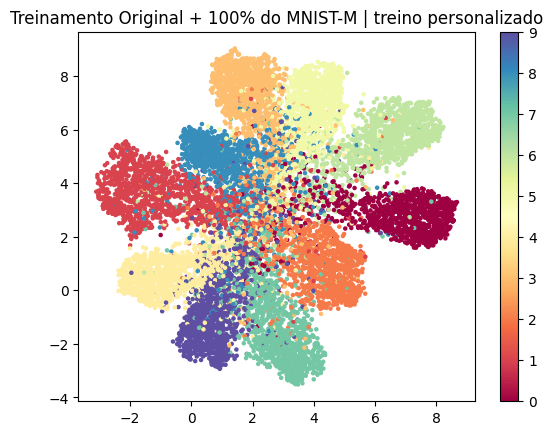

In [168]:
# make clusters

model_embeddings_train_m = triplet_model_p_100.layers[3].predict(mnist_back_train_data_rotated)

model_embeddings_train_m.shape

reduced_embeddings_train_m = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='correlation')\
    .fit_transform(model_embeddings_train_m)

plt.scatter(reduced_embeddings_train_m[:, 0], reduced_embeddings_train_m[:,1], c=mnist_back_train_label, cmap='Spectral', s=5)
plt.title("Treinamento Original + 100% do MNIST-M | treino personalizado")
plt.colorbar()

# Terceiro domínio

In [218]:
from sklearn.utils import shuffle

# read amat
mnist_random_back_train_data = np.loadtxt('mnist_background_random//mnist_background_random_train.amat')
mnist_random_back_test_data = np.loadtxt('mnist_background_random//mnist_background_random_test.amat')

mnist_random_back_train_label = mnist_random_back_train_data[:,-1]
mnist_random_back_test_label = mnist_random_back_test_data[:,-1]

mnist_random_back_train_data, mnist_random_back_train_label = shuffle(mnist_random_back_train_data, mnist_random_back_train_label)
mnist_random_back_test_data, mnist_random_back_test_label = shuffle(mnist_random_back_test_data, mnist_random_back_test_label)

mnist_random_back_train_data = mnist_random_back_train_data[:,:-1]
mnist_random_back_test_data = mnist_random_back_test_data[:,:-1]

### Não rotacionado

Text(0.5, 1.0, '3.0')

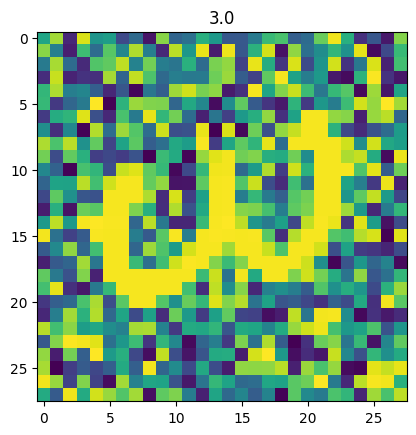

In [219]:
plt.imshow(mnist_random_back_train_data[13].reshape(28,28))
plt.title(mnist_random_back_train_label[13])

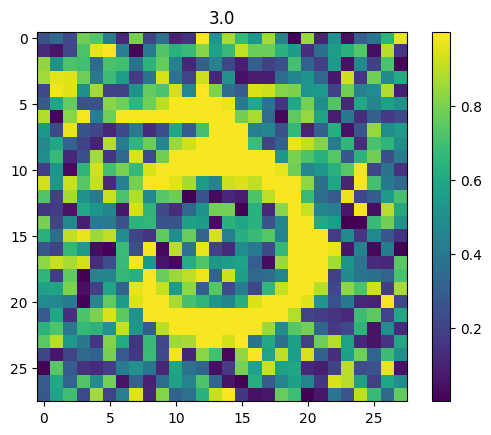

In [220]:

mnist_random_back_train_data = mnist_random_back_train_data.reshape(-1, 28, 28, 1)
mnist_random_back_test_data = mnist_random_back_test_data.reshape(-1, 28, 28, 1)

i = 98
mnist_random_back_train_data_rotated = np.rot90(mnist_random_back_train_data, axes=(1,2))
# revert
mnist_random_back_train_data_rotated = mnist_random_back_train_data_rotated[:,::-1,:]
plt.imshow(mnist_random_back_train_data_rotated[i])
plt.title(mnist_random_back_train_label[i])
plt.colorbar()

# Treinamento

In [222]:
# só com o terceiro domínio, pra ver se ele é bom em generalizar

triplet_model_3d_all = new_model()


all_images, all_labels = gather_all_images(x_train, mnist_random_back_train_data_rotated, y_train, mnist_random_back_train_label)

history = triplet_model_3d_all.fit(data_generator_todos_juntos(), epochs=10, steps_per_epoch=150)


Epoch 1/10
150/150 [==============================] - 7s 30ms/step - loss: 0.3186
Epoch 2/10
150/150 [==============================] - 5s 30ms/step - loss: 0.1703
Epoch 3/10
150/150 [==============================] - 5s 30ms/step - loss: 0.1248
Epoch 4/10
150/150 [==============================] - 5s 31ms/step - loss: 0.0948
Epoch 5/10
150/150 [==============================] - 5s 30ms/step - loss: 0.0813
Epoch 6/10
150/150 [==============================] - 5s 31ms/step - loss: 0.0692
Epoch 7/10
150/150 [==============================] - 5s 31ms/step - loss: 0.0548
Epoch 8/10
150/150 [==============================] - 5s 30ms/step - loss: 0.0588
Epoch 9/10
150/150 [==============================] - 5s 31ms/step - loss: 0.0496
Epoch 10/10
150/150 [==============================] - 4s 30ms/step - loss: 0.0534


375/375 [==============================] - 1s 3ms/step


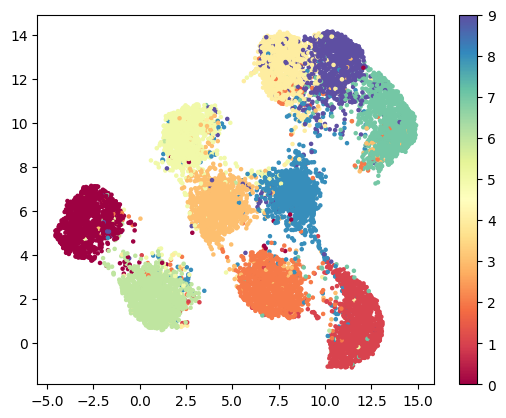

In [224]:
# make clusters

model_embeddings_train_m = triplet_model_3d_all.layers[3].predict(mnist_random_back_train_data_rotated)

model_embeddings_train_m.shape

reduced_embeddings_train_m = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='correlation').fit_transform(model_embeddings_train_m)

plt.scatter(reduced_embeddings_train_m[:, 0], reduced_embeddings_train_m[:,1], c=mnist_random_back_train_label, cmap='Spectral', s=5)
# plt.title("Treinamento Original + 50% do MNIST-M | treino personalizado")
plt.colorbar()

375/375 [==============================] - 1s 3ms/step


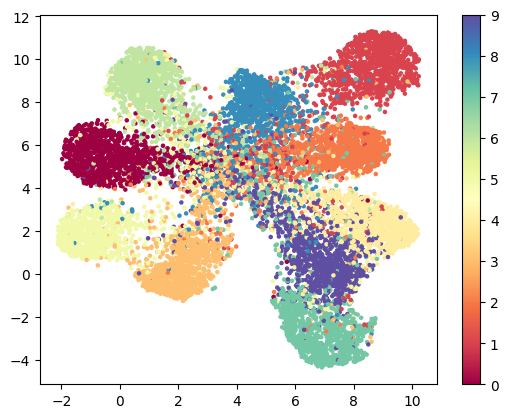

In [225]:
# make clusters

model_embeddings_train_m = triplet_model_3d_all.layers[3].predict(mnist_back_train_data_rotated)

model_embeddings_train_m.shape

reduced_embeddings_train_m = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='correlation').fit_transform(model_embeddings_train_m)

plt.scatter(reduced_embeddings_train_m[:, 0], reduced_embeddings_train_m[:,1], c=mnist_back_train_label, cmap='Spectral', s=5)
# plt.title("Treinamento Original + 50% do MNIST-M | treino personalizado")
plt.colorbar()

## Treinamento personalizado 3 dominio